In [ ]:
!pip install opencv-python mediapipe tensorflow
!pip install mediapipe
!pip install kagglehub

INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35.7/35.7 MB 21.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 294.9/294.9 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incom

In [ ]:
!pip install deep-translator


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42.3/42.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Indian Sign Language Recognition with Real-time Webcam Inference

import os
import random
import shutil
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, clear_output
from IPython.display import Javascript
from PIL import Image
import mediapipe as mp
import time
import kagglehub

In [ ]:

# Constants
DATASET_DIR = "/root/.cache/kagglehub/datasets/prathumarikeri/indian-sign-language-isl/versions/1/Indian"
BASE_DIR = "sign_language_data"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 10
SPLIT_RATIO = 0.8

In [ ]:
# Step 1: Download and split data
kagglehub.dataset_download("prathumarikeri/indian-sign-language-isl")

if not os.path.exists(BASE_DIR):
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for label in os.listdir(DATASET_DIR):
        label_path = os.path.join(DATASET_DIR, label)
        if os.path.isdir(label_path):
            images = [img for img in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, img))]
            random.shuffle(images)
            split_idx = int(len(images) * SPLIT_RATIO)
            train_imgs, val_imgs = images[:split_idx], images[split_idx:]

            os.makedirs(os.path.join(TRAIN_DIR, label), exist_ok=True)
            os.makedirs(os.path.join(VAL_DIR, label), exist_ok=True)

            for img in train_imgs:
                shutil.copyfile(os.path.join(label_path, img), os.path.join(TRAIN_DIR, label, img))
            for img in val_imgs:
                shutil.copyfile(os.path.join(label_path, img), os.path.join(VAL_DIR, label, img))
else:
    print("\u2705 Dataset already prepared.")


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 281M/281M [00:03<00:00, 94.8MB/s]

Extracting files...


In [ ]:
# Step 2: Load data
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')
val_data = val_gen.flow_from_directory(
    VAL_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='categorical')


Found 34195 images belonging to 35 classes.
Found 8550 images belonging to 35 classes.


In [ ]:
# Step 3: Build model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 4: Train model
model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1069/1069 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 245s 228ms/step - accuracy: 0.6780 - loss: 1.1207 - val_accuracy: 0.9991 - val_loss: 0.0038
Epoch 2/10
1069/1069 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 243s 227ms/step - accuracy: 0.9643 - loss: 0.1043 - val_accuracy: 0.9993 - val_loss: 0.0029
Epoch 3/10
1069/1069 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 241s 226ms/step - accuracy: 0.9777 - loss: 0.0653 - val_accuracy: 1.0000 - val_loss: 4.5911e-04
Epoch 4/10
1069/1069 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 246s 230ms/step - accuracy: 0.9830 - loss: 0.0503 - val_accuracy: 0.9999 - val_loss: 4.2957e-04
Epoch 5/10
1069/1069 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 241s 225ms/step - accuracy: 0.9858 - loss: 0.0439 - val_accuracy: 1.0000 - val_loss: 6.0717e-04
Epoch 6/10
1069/1069 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 242s 226ms/step - accuracy: 0.9871 -

In [ ]:
# Step 5: Save model
model.save("sign_language_model.h5")  # Save after training
model = tf.keras.models.load_model("sign_language_model.h5")  # Reload

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Step 6: Real-time webcam input and prediction
model = tf.keras.models.load_model("sign_language_model.h5")
labels = sorted(os.listdir(DATASET_DIR))

hindi_dict = {
    'A': '‡§è', 'B': '‡§¨‡•Ä', 'C': '‡§∏‡•Ä', 'D': '‡§°‡•Ä', 'E': '‡§à',
    'F': '‡§è‡§´', 'G': '‡§ú‡•Ä', 'H': '‡§è‡§ö', 'I': '‡§Ü‡§à', 'J': '‡§ú‡•á',
    'K': '‡§ï‡•á', 'L': '‡§è‡§≤', 'M': '‡§è‡§Æ', 'N': '‡§è‡§®', 'O': '‡§ì',
    'P': '‡§™‡•Ä', 'Q': '‡§ï‡•ç‡§Ø‡•Ç', 'R': '‡§Ü‡§∞', 'S': '‡§è‡§∏', 'T': '‡§ü‡•Ä',
    'U': '‡§Ø‡•Ç', 'V': '‡§µ‡•Ä', 'W': '‡§°‡§¨‡•ç‡§≤‡•ç‡§Ø‡•Ç', 'X': '‡§è‡§ï‡•ç‡§∏', 'Y': '‡§µ‡§æ‡§à', 'Z': '‡§ú‡•á‡§°'
}

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1,
                       min_detection_confidence=0.7, min_tracking_confidence=0.7)

cap = cv2.VideoCapture(0)
prediction_string = ""

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            joints = []
            for lm in hand_landmarks.landmark:
                joints.extend([lm.x, lm.y, lm.z])

            if len(joints) == 63:
                X = np.array(joints).reshape(1, -1)
                try:
                    prediction = model.predict(X)[0]
                    pred_idx = np.argmax(prediction)
                    pred_letter = labels[pred_idx].upper()
                    hindi_translation = hindi_dict.get(pred_letter, "‚Äî")

                    prediction_string += pred_letter

                    cv2.putText(frame, f"Prediction: {pred_letter}", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
                    cv2.putText(frame, f"Hindi: {hindi_translation}", (10, 80),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Word: {prediction_string}", (10, 120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                except:
                    continue

    cv2.imshow("Sign Language Recognition", frame)

    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    elif key == ord('c'):
        prediction_string = ""

cap.release()
#cv2.destroyAllWindows()


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Found 8550 images belonging to 35 classes.
268/268 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 57ms/step - accuracy: 1.0000 - loss: 2.0714e-04
‚úÖ Validation Accuracy: 100.00% | Loss: 0.0002
268/268 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 56ms/step


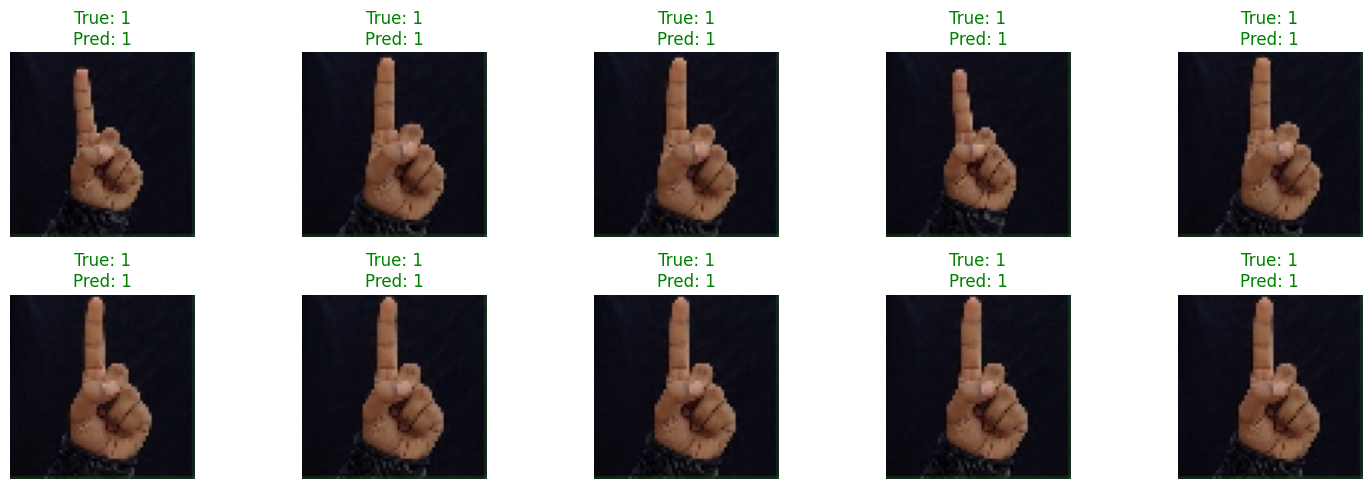

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
VAL_DIR = "/content/sign_language_data/val"  # Replace with actual val path if needed
MODEL_PATH = "/content/sign_language_model.h5"  # Replace with your .h5 model path

# Load the trained model
model = load_model(MODEL_PATH)

# Compile the model so we can evaluate
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Data generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on validation set
loss, acc = model.evaluate(val_data)
print(f"‚úÖ Validation Accuracy: {acc*100:.2f}% | Loss: {loss:.4f}")

# Predict on validation data
preds = model.predict(val_data)
predicted_classes = np.argmax(preds, axis=1)
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Plot some predictions
def plot_predictions(images, true, pred, labels, num=10):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(2, num//2, i + 1)
        plt.imshow(images[i])
        color = "green" if true[i] == pred[i] else "red"
        plt.title(f"True: {labels[true[i]]}\nPred: {labels[pred[i]]}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Since val_data is a generator, we extract actual images
val_data.reset()
images, _ = next(val_data)  # batch of images

# Plot predictions for the first batch
plot_predictions(images, true_classes[:BATCH_SIZE], predicted_classes[:BATCH_SIZE], class_labels)


Found 8550 images belonging to 35 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


268/268 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 56ms/step


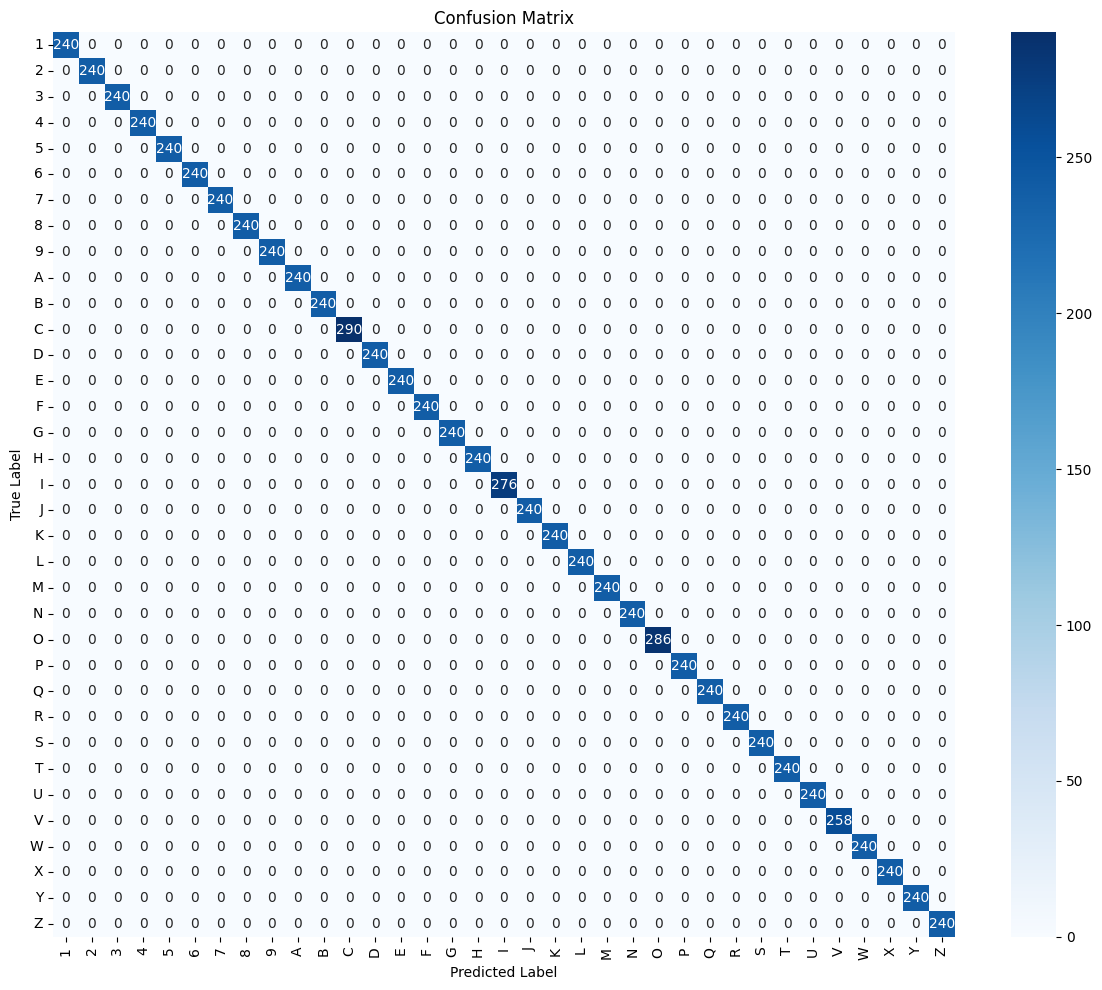

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       240
           3       1.00      1.00      1.00       240
           4       1.00      1.00      1.00       240
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       240
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       240
           A       1.00      1.00      1.00       240
           B       1.00      1.00      1.00       240
           C       1.00      1.00      1.00       290
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      1.00      1.00       240
           G       1.00      1.00      1.00       240
           H       1.00      1.00      1.00       240
   

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
BASE_DIR = "sign_language_data"
VAL_DIR = os.path.join(BASE_DIR, "val")

# Load the trained model
model = load_model("sign_language_model.h5")

# Data generator for validation data
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict on validation data
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
print("Classification Report:\n", report)



In [ ]:
# STEP 1: Upload Model and Setup
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

In [ ]:
# Load trained model
model = load_model("sign_language_model.h5")
print("‚úÖ Model loaded.")


‚úÖ Model loaded.


In [ ]:
# ‚úÖ Get labels directly from the train directory (sorted for consistency)
labels = sorted(os.listdir(TRAIN_DIR))
print("‚úÖ Labels used in the model:", labels)

‚úÖ Labels used in the model: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
# Define class labels (adjust based on your training)
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [ ]:
# STEP 2: Webcam Capture via JS
def capture_image():
    display(Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'üì∑ Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize video output
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            capture.onclick = () => {
              canvas.width = video.videoWidth;
              canvas.height = video.videoHeight;
              canvas.getContext('2d').drawImage(video, 0, 0);
              stream.getTracks().forEach(track => track.stop());
              div.remove();
              const dataURL = canvas.toDataURL('image/jpeg');
              google.colab.kernel.invokeFunction('notebook.get_webcam_image', [dataURL], {});
            };
        }
        takePhoto();
    '''))


In [ ]:
# STEP 3: Callback to receive the webcam image
from google.colab import output
from IPython.display import Image as IPyImage

captured_image_data = None

def get_webcam_image(data_url):
    global captured_image_data
    header, encoded = data_url.split(",", 1)
    binary = b64decode(encoded)
    captured_image_data = binary

output.register_callback('notebook.get_webcam_image', get_webcam_image)


In [ ]:
# STEP 4: Prediction Function
def predict_image(img_bytes):
    global predicted_label
    global prediction
    img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape((1, IMG_HEIGHT, IMG_WIDTH, 3))
    prediction = model.predict(img_array)
    predicted_label = labels[np.argmax(prediction)]
    return predicted_label, img

In [ ]:
# STEP 5: Run Inference Loop
def run_realtime_prediction():
    capture_image()
    import time
    time.sleep(5)  # Wait for user to click capture

    if captured_image_data:
        pred_label, shown_image = predict_image(captured_image_data)
        print(f"üî§ Predicted ISL Letter: **{pred_label}**")
        display(shown_image)
    else:
        print("‚ùå No image captured. Try again.")

In [ ]:
# CALL THIS TO START
run_realtime_prediction()

<IPython.core.display.Javascript object>

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 108ms/step
üî§ Predicted ISL Letter: **O**
